Plot dataset stuff

In [1]:
import math
import pathlib

import numpy
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl

from helpers.data.file_hand import load_file_agg_raw_signal
from helpers.data.dset.constants import Names_Levels, Trials_Splits, Names_Labels, Names_Variables
from helpers.plot.util import  add_plot_note, setup_high_quality_mpl_params


setup_high_quality_mpl_params()

path_dir_data = pathlib.Path("../../state/new_physics/data/processed")
path_dir_plots = pathlib.Path("../../state/new_physics/plots")

dfs = {
    level : load_file_agg_raw_signal(
        dir=path_dir_data,
        level=level,
        trials=Trials_Splits().train,
    ) for level in (
        Names_Levels().generator, 
        Names_Levels().detector,
    )
}

Opened ..\..\state\new_physics\data\processed\agg_sig_1_to_20_gen.pkl
Loaded aggregated raw signal data file: ..\..\state\new_physics\data\processed\agg_sig_1_to_20_gen.pkl
Opened ..\..\state\new_physics\data\processed\agg_sig_1_to_20_det.pkl
Loaded aggregated raw signal data file: ..\..\state\new_physics\data\processed\agg_sig_1_to_20_det.pkl


Variables

In [ ]:


levels = (
    Names_Levels().generator, 
    Names_Levels().detector
)

paths_files = {
    level : path_dir_plots.joinpath(
        f"variables_{level}.png"
    )
    for level in levels
}

nums_events = {
    level : f"{len(dfs[level])/44 :.0e}"
    for level in levels
}

notes = {
    Names_Levels().generator : f"Generator, ~{nums_events[Names_Levels().generator]} events / " + r"$\delta C_9$",
    Names_Levels().detector : f"Detector, ~{nums_events[Names_Levels().detector]} events / " + r"$\delta C_9$",
}

cmap = plt.cm.coolwarm
norm = mpl.colors.CenteredNorm(
    vcenter=0, 
    halfrange=abs(
        dfs
        [Names_Levels().generator]
        [Names_Labels().unbinned]
        .min()
    )
)

xlabels = {
    Names_Variables().q_squared : r"$q^2$",
    Names_Variables().cos_theta_mu : r"$\cos\theta_\mu$",
    Names_Variables().cos_k : r"$\cos\theta_K$",
    Names_Variables().chi : r"$\chi$"
}

xlims = {
    Names_Variables().q_squared : (0, 20),
    Names_Variables().cos_theta_mu : (-1, 1),
    Names_Variables().cos_k : (-1, 1),
    Names_Variables().chi : (0, 2*math.pi),
}

ylims = {
    Names_Variables().q_squared : (0, 0.14),
    Names_Variables().cos_theta_mu : (0, 0.75),
    Names_Variables().cos_k : (0, 0.85),
    Names_Variables().chi : (0, 0.195),
}

for level in levels:

    fig, axs = plt.subplots(
        2, 2, 
        sharey=False, 
        layout="compressed"
    )

    for variable, ax in zip(Names_Variables().tuple_, axs.flat):

        for label, df in dfs[level].groupby(
            Names_Labels().unbinned,    
        ):
            
            is_standard_model = (label == 0)
            
            color = (
                cmap(norm(label))
                if not is_standard_model
                else "dimgrey"
            )

            linestyle = (
                None
                if not is_standard_model
                else (0, (1, 1))
            )

            label_legend = (
                None
                if not is_standard_model
                else r"SM ($\delta C_9 = 0$)"
            )

            zorder = (
                None
                if not is_standard_model
                else 10
            )

            ax.hist(
                df[variable], 
                range=xlims[variable],
                histtype="step",
                density=True, 
                bins=30, 
                color=color,
                linestyle=linestyle,
                label=label_legend,
                zorder=zorder,
            )
        
        ax.set_xlabel(
            xlabels[variable]
        )

        if variable == Names_Variables().chi:
            ax.set_xticks(
                [0, math.pi, 2*math.pi], 
                ["0", r"$\pi$", r"$2 \pi$"],
            )

        ax.set_ylim(ylims[variable])

        ax.locator_params(axis='y', tight=True, nbins=2)

    add_plot_note(axs[0,1], notes[level])
    axs[0,0].legend()
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical', label=r'$\delta C_9$')

    plt.savefig(paths_files[level], bbox_inches="tight")
    plt.close()


Asymmetries

In [2]:
def bin_data(
    df,
    name_variable, 
    start, 
    stop, 
    num_bins,
    return_bin_edges=False,
):
    
    bin_edges = numpy.linspace(
        start=start,
        stop=stop,
        num=num_bins+1,
    )

    bins = pandas.cut(
        df[name_variable], 
        bin_edges, 
        include_lowest=True
    ) # the interval each event falls into

    groupby_binned = df.groupby(bins)

    if return_bin_edges:
        return groupby_binned, bin_edges

    return groupby_binned


def calc_bin_middles(start, stop, num_bins):

    bin_edges, step = numpy.linspace(
        start=start,
        stop=stop,
        num=num_bins+1,
        retstep=True,
    )

    bin_middles = bin_edges[:-1] + step/2 
    return bin_middles


def calc_afb_of_q_squared(df, num_bins):
    """
    Calcuate Afb as a function of q squared.
    Afb is the forward-backward asymmetry.
    """

    def get_column_cos_theta_mu(df):
        column = df[Names_Variables().cos_theta_mu]
        return column
    
    def calc_num_forward(df):
        series_cos_theta_mu = get_column_cos_theta_mu(df)
        f = series_cos_theta_mu[(series_cos_theta_mu > 0) & (series_cos_theta_mu < 1)].count()
        return f
    
    def calc_num_backward(df):
        series_cos_theta_mu = get_column_cos_theta_mu(df)
        b = series_cos_theta_mu[(series_cos_theta_mu > -1) & (series_cos_theta_mu < 0)].count()
        return b

    def _calc_afb(df):

        f = calc_num_forward(df)
        b = calc_num_backward(df)

        afb = (f - b) / (f + b)
        return afb

    def _calc_afb_err(df):

        f = calc_num_forward(df)
        b = calc_num_backward(df)

        f_stdev = math.sqrt(f)
        b_stdev = math.sqrt(b)

        afb_stdev = 2*f*b / (f+b)**2 * math.sqrt((f_stdev/f)**2 + (b_stdev/b)**2)
        afb_err = afb_stdev

        return afb_err

    q_squared_bound_lower = 0
    q_squared_bound_upper = 20

    df = df[
        (df[Names_Variables().q_squared]>q_squared_bound_lower) 
        & (df[Names_Variables().q_squared]<q_squared_bound_upper)
    ]

    groupby_binned = bin_data(
        df=df, 
        name_variable=Names_Variables().q_squared, 
        start=q_squared_bound_lower,
        stop=q_squared_bound_upper,
        num_bins=num_bins,     
    )
    
    afbs = groupby_binned.apply(_calc_afb)
    errs = groupby_binned.apply(_calc_afb_err)

    bin_middles = calc_bin_middles(
        start=q_squared_bound_lower, 
        stop=q_squared_bound_upper, 
        num_bins=num_bins,
    )

    return bin_middles, afbs, errs


    

In [5]:

def calc_halfrange_colorbar():

    def get_lowest_label(df):
        label = df[Names_Labels().unbinned].min()
        return label

    value = abs(
        get_lowest_label(
            dfs[Names_Levels().generator]
        )
    )
    return value


def plot_afb(num_bins, alpha=0.85):
    
    fig, ax = plt.subplots()
    
    cmap = plt.cm.coolwarm
    norm = mpl.colors.CenteredNorm(
        vcenter=0, 
        halfrange=calc_halfrange_colorbar(),
    )
    
    for label, df in (
        dfs[Names_Levels().generator]
        .groupby(Names_Labels().unbinned)
    ):
        
        color = cmap(norm(label))

        bin_middles, afbs, afb_errs = calc_afb_of_q_squared(
            df=df, 
            num_bins=num_bins,
        )

        ax.scatter(
            bin_middles, 
            afbs, 
            color=color, 
            alpha=alpha,
        )

        ax.errorbar(
            bin_middles, 
            afbs, 
            yerr=afb_errs, 
            fmt='none', 
            ecolor=color, 
            elinewidth=0.3, 
            capsize=0, 
            alpha=alpha
        )

    fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax=ax, 
        orientation='vertical', 
        label=r'$\delta C_9$',
    )

    path = path_dir_plots.joinpath("afb_gen.png")
    plt.savefig(path, bbox_inches="tight")





        

        



    

C:\Users\tetha\AppData\Local\Temp\ipykernel_19512\3629816247.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby_binned = df.groupby(bins)


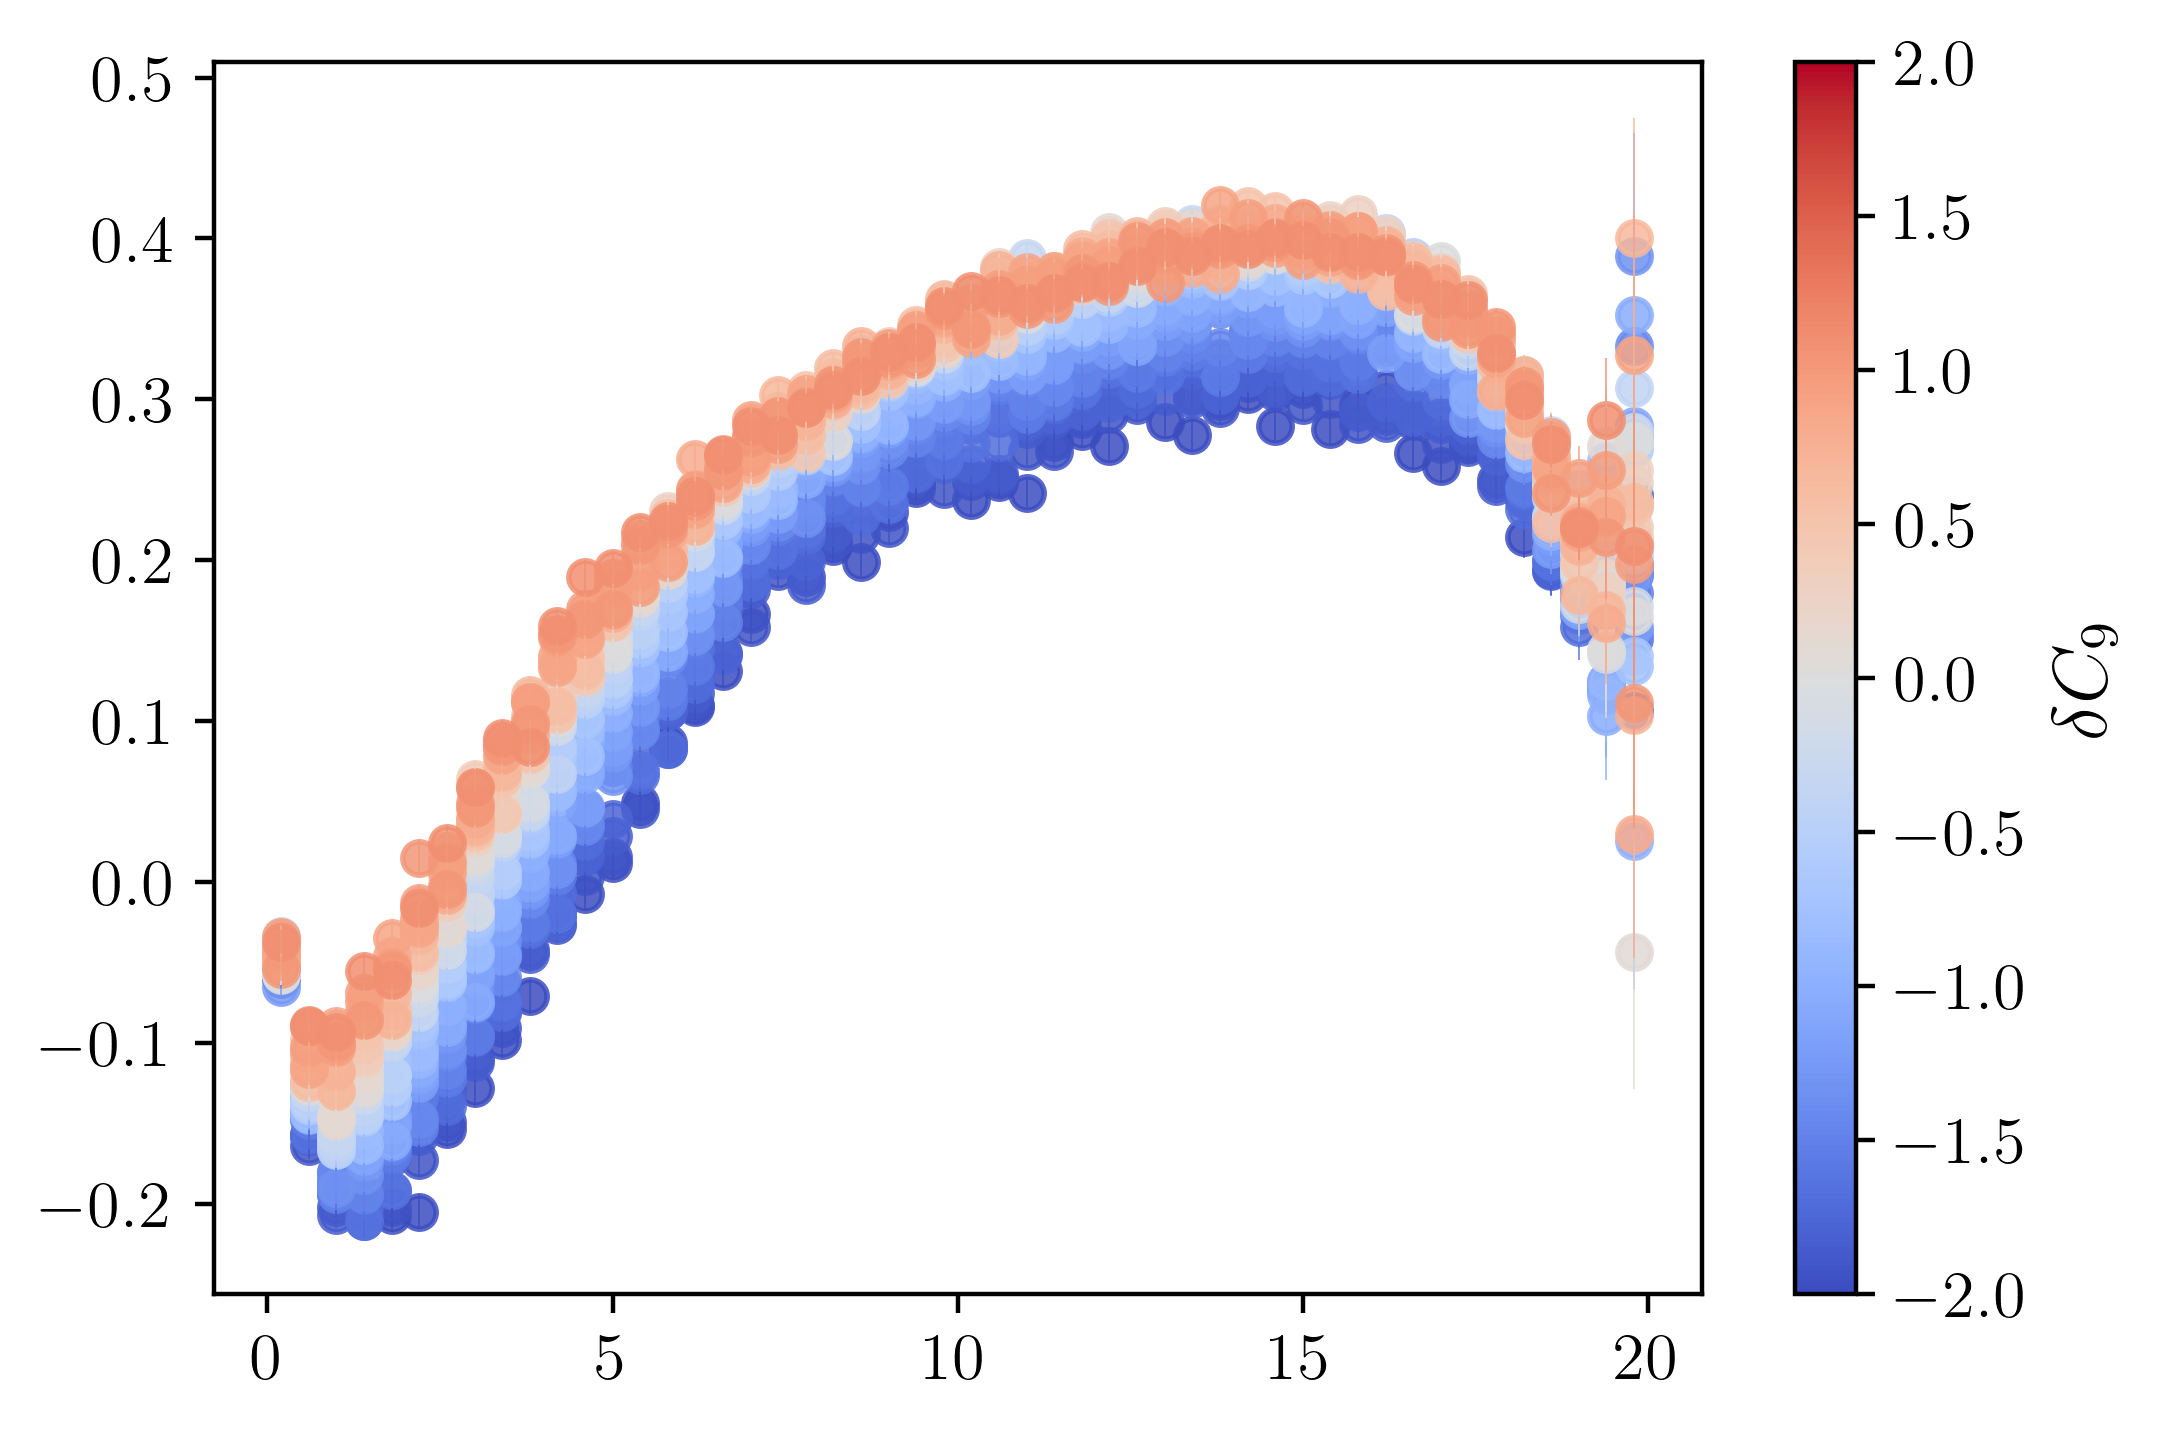

In [6]:
plot_afb(num_bins=50)